In [47]:
import os
import random
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from glob import glob
from scipy.io import wavfile
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, Image, SVG
import sys
import numpy as np

# Séparation de sources

La séparation de sources audio vise à extraire des signaux distincts à partir d’un enregistrement mélangé. Dans ce projet, nous nous concentrons sur la séparation de deux sources spécifiques dans un jeu de données contrôlé : un signal "propre", représentant un enregistrement vocal, et un signal "bruyant", constitué de sons de rue tels que des conversations, des pas et des véhicules.

## Exploration de données

### Taille des données

In [19]:
TRAIN_DIR = '../source_separation/data/source_separation/train'
TEST_DIR = '../source_separation/data/source_separation/test'

In [3]:
def count_dirs(directory):
    return sum(len(dirs) for _, dirs, _ in os.walk(directory))

In [21]:
nb_train = count_dirs(TRAIN_DIR)
nb_test = count_dirs(TEST_DIR)

print(f"Taille des données d'entraînement: {nb_train}")
print(f"Taille des données de test: {nb_test}")

Taille des données d'entraînement: 5000
Taille des données de test: 2000


### Visualisation des Données

Nous commençons par explorer un échantillon des signaux disponibles.

In [24]:
index = str(random.randint(0, nb_train-1)).zfill(4)
path = f'{TRAIN_DIR}/{index}'

for filename in os.listdir(path):
    if filename == "voice.wav":
        voice, sr = torchaudio.load(f"{path}/voice.wav")
        print("voice.wav")
        display(Audio(voice, rate=sr))
    elif filename == "noise.wav":
        noise, sr = torchaudio.load(f"{path}/noise.wav")
        print("noise.wav")
        display(Audio(noise, rate=sr))
    elif filename.startswith("mix_snr"):
        mix_audio, sr = torchaudio.load(f"{path}/{filename}")
        print("mix_snr_XX.wav")
        display(Audio(mix_audio, rate=sr))

mix_snr_XX.wav


noise.wav


voice.wav


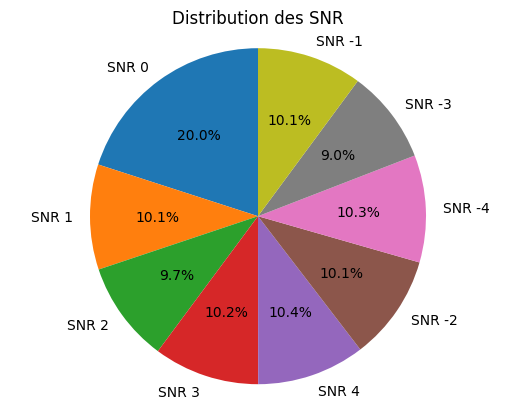

In [33]:
snr_values = [
    int(filename.split('_')[2].split('.')[0])
    for subdir in os.listdir(TRAIN_DIR)
    for filename in os.listdir(os.path.join(TRAIN_DIR, subdir))
    if filename.startswith("mix_snr_")
]

snr_counts = {snr: snr_values.count(snr) for snr in set(snr_values)}

plt.pie(snr_counts.values(), labels=[f"SNR {snr}" for snr in snr_counts], autopct='%1.1f%%', startangle=90)
plt.title('Distribution des SNR')
plt.axis('equal')
plt.show()

On observe que les valeurs de SNR varient entre -4 et 4, avec une concentration plus importante de données autour de SNR = 0. Pour les autres valeurs, la distribution est relativement équilibrée.

In [56]:
for snr in [4, 0, -4]:
    for subdir in os.listdir(TRAIN_DIR):
        subdir_path = os.path.join(TRAIN_DIR, subdir)
        
        if os.path.isdir(subdir_path):
            file_path = os.path.join(subdir_path, f"mix_snr_{snr}.wav")
            
            if os.path.exists(file_path):
                audio, sr = torchaudio.load(file_path)
                print(f'mix_snr_{snr}.wav')
                display(Audio(audio, rate=sr))
                break

mix_snr_4.wav


mix_snr_0.wav


mix_snr_-4.wav


On observe clairement que plus le SNR diminue, plus il devient difficile d'entendre la parole de manière claire.

## Baseline

Nous allons d'abord établir une baseline pour tester notre pipeline d'entraînement.

In [4]:
SIGNAL_LENGTH = 80000

def get_segments(audio, segment_length=16384):
    num_samples = audio.shape[1]
    num_segments = num_samples // segment_length
    segments = []
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        segments.append(audio[:, start_idx:end_idx])
    remaining_samples = num_samples % segment_length
    if remaining_samples > 0:
        last_segment = audio[:, num_segments * segment_length:]
        # Calculer combien il manque
        missing_samples = segment_length - remaining_samples
        # Répéter les échantillons restants pour combler
        repeated_segment = torch.cat([last_segment, last_segment[:, :missing_samples]], dim=1)
        segments.append(repeated_segment)
    return segments

def get_audio(file):
    audio, _ = torchaudio.load(file)
    return audio / audio.abs().max()

def resize_audio(audio, target_length):
    audio_resized = F.interpolate(audio.unsqueeze(0), size=(target_length), mode='linear', align_corners=False)
    return audio_resized.squeeze(0)

class AudioDataset(Dataset):
    def __init__(self, data_path, segment_length=16384):
        self.data_path = data_path
        self.files = self._load_files()
        self.segment_length = segment_length
        self.samples = self._load_samples()

    def _load_files(self):
        files = []
        for subfolder in os.listdir(self.data_path):
            path = os.path.join(self.data_path, subfolder)
            files.append(
                (
                    list(glob(os.path.join(path, "mix_snr_*.wav")))[0],
                    os.path.join(path, 'voice.wav'),
                    os.path.join(path, 'noise.wav')
                )
            )
        return files
    
    def _load_samples(self):
        samples = []
        for signals_files in self.files:
            mix_file, voice_file, noise_file = signals_files
            if self.segment_length <= SIGNAL_LENGTH:
                mix_segments = get_segments(get_audio(mix_file), segment_length=self.segment_length)
                voice_segments = get_segments(get_audio(voice_file), segment_length=self.segment_length)
                noise_segments = get_segments(get_audio(noise_file), segment_length=self.segment_length)
                for mix_segment, voice_segment, noise_segment in zip(mix_segments, voice_segments, noise_segments):
                    samples.append((mix_segment, voice_segment, noise_segment))
            else:
                mix_audio = resize_audio(get_audio(mix_file), target_length=147443)
                voice_audio = resize_audio(get_audio(voice_file), target_length=16389)
                noise_audio = resize_audio(get_audio(noise_file), target_length=16389)
                samples.append((mix_audio, voice_audio, noise_audio))
        return samples
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        mix_audio, voice_audio, noise_audio = self.samples[idx]
        return mix_audio, voice_audio, noise_audio

def get_dataloader(data_path, segment_length, batch_size=16, shuffle=True, collate_fn=None):
    dataset = AudioDataset(data_path, segment_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return dataloader


In [90]:
def train(model, train_loader, valid_loader, criterion, optimizer, device="cpu", n_epochs=20, save_path="models/model.pth", log_dir="runs/experiment"):
    writer = SummaryWriter(log_dir=log_dir)
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(n_epochs):
        pbar = tqdm(train_loader, unit="batches")
        model.train()
        train_loss = 0.0
        for batch_mix, batch_signal, batch_noise in pbar:
            batch_mix, batch_signal, batch_noise = batch_mix.to(device), batch_signal.to(device), batch_noise.to(device)
            batch_signal_pred, batch_noise_pred = model(batch_mix)
            loss = _compute_loss(criterion, batch_signal_pred, batch_signal, batch_noise_pred, batch_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar("Loss/Train", train_loss, epoch + 1)

        # Validation
        model.eval()
        val_loss = 0.0
        val_sdr = 0.0
        with torch.no_grad():
            for batch_mix, batch_signal, batch_noise in valid_loader:
                batch_mix, batch_signal, batch_noise = batch_mix.to(device), batch_signal.to(device), batch_noise.to(device)
                batch_signal_pred, batch_noise_pred = model(batch_mix)
                loss = _compute_loss(criterion, batch_signal_pred, batch_signal, batch_noise_pred, batch_noise)
                val_loss += loss.item()

                sdr = calculate_sdr(batch_signal, batch_signal_pred)
                val_sdr += sdr.item()
        
        val_sdr /= len(valid_loader)
        val_loss /= len(valid_loader)
        writer.add_scalar("Loss/Validation", val_loss, epoch + 1)
        writer.add_scalar("Metrics/SDR", val_sdr, epoch + 1)

        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Voice SDR: {val_sdr:.6f} dB")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break

def _compute_loss(criterion, signal_pred, signal, noise_pred, noise):
    return (criterion(signal_pred, signal) + criterion(noise_pred, noise)) / 2

def calculate_sdr(signal, pred):
    norm_signal_clean = torch.norm(signal)
    norm_residual_error = torch.norm(signal - pred)
    return 10 * torch.log10(norm_signal_clean ** 2 / norm_residual_error ** 2)

In [101]:
class BaselineModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(BaselineModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(16, 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(8, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return torch.chunk(self.decoder(self.encoder(x)), 2, dim=1)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
save_path = './models/baseline.pth'
log_dir = './runs/baseline'

train_loader = get_dataloader(TRAIN_DIR, batch_size=16, shuffle=True)
valid_loader = get_dataloader(TEST_DIR, batch_size=16, shuffle=True)

In [54]:
for batch in train_loader:
    print(f"Taille du batch: {batch[0].size()}")
    break

Taille du batch: torch.Size([16, 1, 80000])


Nous avons entraîné ce modèle pendant 50 epochs avec une fonction de perte MSE et l'optimiseur Adam avec un taux d'apprentissage de 0.001.

In [103]:
baseline = BaselineModel()
baseline.load_state_dict(torch.load('./models/baseline.pth', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [32]:
mix_tensor = mix_audio / mix_audio.abs().max()

model.eval()
with torch.no_grad():
    signal_pred, noise_pred = model(mix_tensor.unsqueeze(0))

In [33]:
print("mix_snr_XX.wav")
display(Audio(mix_audio, rate=sr))

print("Voix prédite")
display(Audio(signal_pred.squeeze(0).numpy(), rate=sr))

mix_snr_XX.wav


Voix prédite


Nous observons la prédiction de la voix réalisée par notre modèle. Bien qu'il y ait du travail à faire pour affiner le filtrage, nous allons maintenant nous attaquer à Wave-U-Net.

## Wave-U-NET

Wave-U-Net est une architecture de réseau neuronal conçue spécifiquement pour la séparation de sources audio dans le domaine temporel. Contrairement à d'autres méthodes qui travaillent dans le domaine des spectrogrammes ou des coefficients de Fourier, Wave-U-Net opère directement sur les signaux audio bruts. Ce modèle, inspiré de l'architecture U-Net utilisée en traitement d'images, utilise des couches de convolution et de déconvolution pour séparer les sources tout en préservant les détails temporels.

L'approche de Wave-U-Net est particulièrement adaptée aux tâches de séparation de sources audio, telles que la séparation voix/bruit, car elle peut exploiter les informations locales du signal tout en apprenant des représentations efficaces des sources sous-jacentes.

In [71]:
Image(url="https://raw.githubusercontent.com/f90/Wave-U-Net/master/waveunet.png", width=400)

### Données et entraînement

Nous allons diviser notre signal en segments d'environ 2 secondes, soit une taille approximative de $\textbf{16 384}$ échantillons par segment. Cette approche permet d'obtenir une taille convenable pour notre modèle tout en évitant de surcharger la mémoire.

Les différentes variantes du modèle ont été entraînées sur $\textbf{50}$ époques, avec une fonction de perte $\textbf{MSE}$ et un optimiseur Adam utilisant un taux d'apprentissage de $\textbf{0.0001}$, ainsi que des paramètres betas respectifs de $\textbf{0.9}$ et $\textbf{0.999}$. La métrique utilisée pour évaluer la performance sur la vois est $\textbf{SDR}$ (Signal-to-Distortion Ratio), qui mesure la qualité de la séparation en évaluant le rapport entre le signal cible reconstruit et les distorsions restantes.

$$
\text{SDR} = 10 \cdot \log_{10} \left( \frac{\| \text{signal}_\text{cible} \|^2}{\| \text{signal}_\text{erreur} \|^2} \right)
$$

- $\text{signal}_\text{cible}$ : La partie du signal estimé qui correspond au signal original.
- $\text{signal}_\text{erreur}$ : La différence entre le signal estimé et le signal cible, représentant les distorsions (bruit résiduel, artefacts, etc.)

### Architecture

In [104]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, is_final=False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.activation = nn.Tanh() if is_final else nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=15):
        super(DownSamplingBlock, self).__init__()
        self.conv = ConvLayer(in_channels, out_channels, kernel_size)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, ::2], x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, kernel_size=5):
        super(UpSamplingBlock, self).__init__()
        self.conv =  ConvLayer(in_channels + skip_channels, out_channels, kernel_size)
        self.interp_layer = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)

    def forward(self, x, skip):
        x = self.interp_layer(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class WaveUNet(nn.Module):
    def __init__(self, in_channels=1, base_filters=24, f_d=15, f_u=5, num_levels=12):
        super(WaveUNet, self).__init__()
        self.downsampling_blocks = nn.ModuleList()
        self.upsampling_blocks = nn.ModuleList()
        self.in_channels = in_channels
        for i in range(num_levels):
            out_channels = base_filters * (i + 1)
            self.downsampling_blocks.append(
                DownSamplingBlock(self.in_channels, out_channels, f_d)
            )
            self.in_channels = out_channels
        out_channels = base_filters * (num_levels + 1)
        self.bottleneck = ConvLayer(self.in_channels, out_channels, f_d)
        self.in_channels = out_channels
        for i in range(num_levels, 0, -1):
            skip_channels = base_filters * i
            out_channels = base_filters * i
            self.upsampling_blocks.append(
                UpSamplingBlock(self.in_channels, out_channels, skip_channels, kernel_size=f_u)
            )
            self.in_channels = out_channels
        self.final_conv = ConvLayer(self.in_channels + 1, 2, kernel_size=1, is_final=True)

    def forward(self, x):
        input_original = x
        skip_connections = []
        for block in self.downsampling_blocks:
            x, x_skip = block(x)
            skip_connections.append(x_skip)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for i, block in enumerate(self.upsampling_blocks):
            skip = skip_connections[i]
            x = block(x, skip)
        x = torch.cat([x, input_original], dim=1)
        x = self.final_conv(x)
        return torch.chunk(x, 2, dim=1)


In [106]:
model = WaveUNet()
model.load_state_dict(torch.load('./models/WaveUNet_MSE_v4.pth', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [80]:
def predict(model, mix_signal, segment_length=16384):
    mix_tensor = mix_signal / mix_signal.abs().max()
    segments = get_segments(mix_tensor)
    
    model.eval()
    with torch.no_grad():
        signals, noises = [], []
    
        for mix_segment in segments:
            signal_pred, noise_pred = model(mix_segment.unsqueeze(0))
            signals.append(signal_pred)
            noises.append(noise_pred)
        
    remaining_samples = mix_signal.shape[1] % segment_length
    signal = torch.cat(signals, dim=2)
    noise = torch.cat(noises, dim=2)
    if remaining_samples > 0:
        signal = signal[:, :, :-(segment_length - remaining_samples)]
        noise = noise[:, :, :-(segment_length - remaining_samples)]

    return signal.squeeze(0), noise.squeeze(0)    

In [81]:
signal, noise = predict(model, mix_audio)

In [82]:
print("mix_snr_XX.wav")
display(Audio(mix_audio, rate=sr))

print("Voix prédite")
display(Audio(signal, rate=sr))

print("Bruit prédit")
display(Audio(noise, rate=sr))

mix_snr_XX.wav


Voix prédite


Bruit prédit


On peut constater que notre modèle a bien progressé. Il a réussi à séparer la voix du bruit de manière efficace. Bien que la voix ne soit pas parfaitement audible, la tâche de séparation a été réalisée de façon satisfaisante.

### Premiers résultats

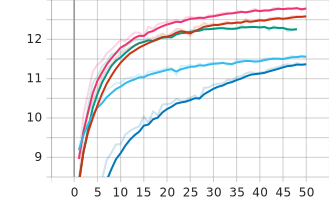

In [62]:
display(SVG(filename="./images/Metrics_SDR.svg"))

On peut voir les différents SDR obtenus par nos modèles actuels, atteignant jusqu'à 12,8 dB.

In [96]:
def mean_sdr(model, data_path):
    sdr_per_snr = {}
    subfolders = os.listdir(data_path)
    for subfolder in tqdm(subfolders, desc="Processing subfolders", unit="folder"):
        path = os.path.join(data_path, subfolder)
        mix_file = glob(os.path.join(path, "mix_snr_*.wav"))[0]
        mix_audio = get_audio(mix_file)
        voice_audio = get_audio(os.path.join(path, 'voice.wav'))
        predicted_voice, _ = predict(model, mix_audio)
        sdr = calculate_sdr(voice_audio, predicted_voice)
        snr_value = int(os.path.basename(mix_file).split("_")[-1].replace(".wav", ""))
        if snr_value not in sdr_per_snr:
            sdr_per_snr[snr_value] = []
        sdr_per_snr[snr_value].append(sdr)
    return {snr: np.mean(sdr_list) for snr, sdr_list in sdr_per_snr.items()}

In [97]:
waveunet_mean_sdr = mean_sdr(model, "./data/source_separation/test")

Processing subfolders: 100%|███████████████████████████████████████████████████| 2000/2000 [18:51<00:00,  1.77folder/s]


In [107]:
baseline_mean_sdr = mean_sdr(baseline, "./data/source_separation/test")

Processing subfolders: 100%|███████████████████████████████████████████████████| 2000/2000 [01:56<00:00, 17.16folder/s]


In [112]:
def compare_sdr_multi(models_sdr):
    common_snrs = sorted(
        set.intersection(*[set(sdr.keys()) for sdr in models_sdr.values()])
    )
    model_names = list(models_sdr.keys())
    values = {name: [models_sdr[name][snr] for snr in common_snrs] for name in model_names}
    x = range(len(common_snrs))
    width = 0.8 / len(model_names)  # Largeur des barres pour éviter les chevauchements
    plt.figure(figsize=(12, 7))
    for i, model_name in enumerate(model_names):
        offset = width * i
        plt.bar(
            [p + offset for p in x],
            values[model_name],
            width=width,
            label=model_name,
            edgecolor='black'
        )
    plt.xticks([p + width * (len(model_names) / 2) for p in x], common_snrs)
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('Mean SDR (dB)', fontsize=12)
    plt.title('Comparison of Mean SDR for Voice', fontsize=14)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

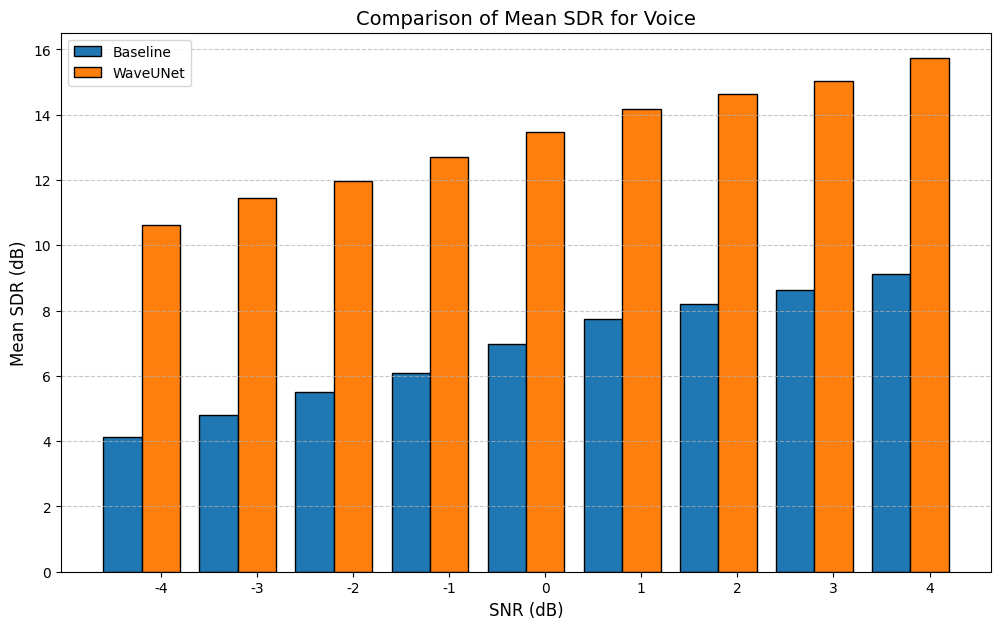

In [113]:
models_sdr = {
    'Baseline': baseline_mean_sdr,
    'WaveUNet': waveunet_mean_sdr
}

compare_sdr_multi(models_sdr)